# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

from zensols.deeplearn import TorchConfig
# set the random seed so things are predictable
TorchConfig.set_random_seed()

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn.result import ModelResultGrapher

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris-poor.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config, shared=True)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 2 (11.8%)
        test: 3 (17.6%)
        train: 12 (70.6%)
        total: 17
    total this instance: 17
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation if `create_model`.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor.create_model())

IrisNetwork(
  (fc): DeepLinearLayer(
    (seq_layers): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

train: 1.291, valid: 0.678 /\: 100%|███████████| 10/10 [00:00<00:00, 51.02it/s]


Name: Iris
Run index: 1
Learning rate: 0.5
    train:
        started: 05/26/2020 00:04:59:775684
        ended: 05/26/2020 00:04:59:972431
        num epochs: 10
        num data points per epoc: 113
        loss: 0.010952696581481115
        num outcomes: 1130
        epoch convergence: 3
        micro: F1: 0.638, precision: 0.64, recall: 0.64
        macro: F1: 0.636, precision: 0.63, recall: 0.64
    validation:
        num epochs: 10
        num data points per epoc: 12
        loss: 0.048044215080638726
        num outcomes: 120
        epoch convergence: 1
        micro: F1: 0.833, precision: 0.83, recall: 0.83
        macro: F1: 0.792, precision: 0.93, recall: 0.78
    test:
        started: 05/26/2020 00:05:00:037329
        ended: 05/26/2020 00:05:00:038995
        num epochs: 1
        num data points per epoc: 25
        loss: 0.051466353178024296
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.680, precision: 0.68, recall: 0.68
        macro: F1:

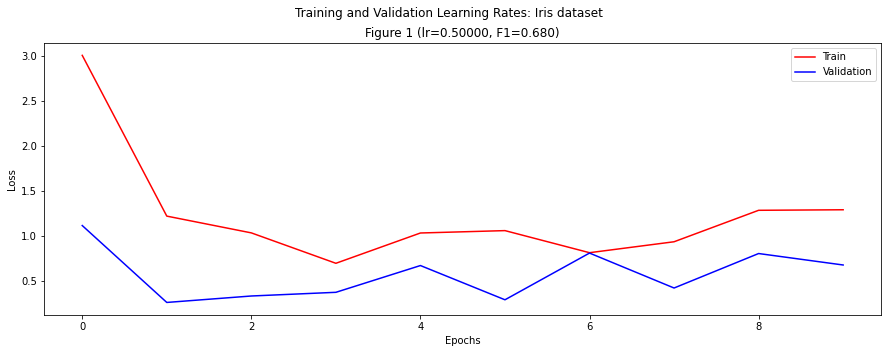

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the executor.

train: 0.270, valid: 0.308 \/: 100%|█████████| 200/200 [00:20<00:00,  9.99it/s]


Name: Iris
Run index: 2
Learning rate: 0.001
    train:
        started: 05/26/2020 00:05:00:353414
        ended: 05/26/2020 00:05:20:379343
        num epochs: 200
        num data points per epoc: 113
        loss: 0.0032833843824866976
        num outcomes: 22600
        epoch convergence: 199
        micro: F1: 0.896, precision: 0.90, recall: 0.90
        macro: F1: 0.898, precision: 0.91, recall: 0.90
    validation:
        num epochs: 200
        num data points per epoc: 12
        loss: 0.03331537290890184
        num outcomes: 2400
        epoch convergence: 199
        micro: F1: 0.923, precision: 0.92, recall: 0.92
        macro: F1: 0.916, precision: 0.92, recall: 0.93
    test:
        started: 05/26/2020 00:05:20:713103
        ended: 05/26/2020 00:05:20:714675
        num epochs: 1
        num data points per epoc: 25
        loss: 0.01106639528274536
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.880, precision: 0.88, recall: 0.88
        m

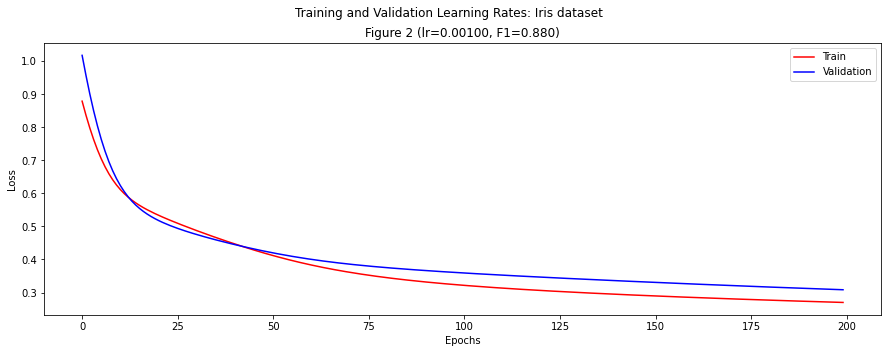

In [6]:
def run_model():
    # reset all state from the previous train/test
    executor.reset()
    # train/test
    executor.train()
    res = executor.test()
    # results
    res.write()
    grapher = ModelResultGrapher('Iris dataset', [15, 5])
    grapher.plot([res])

# set the number of epochs and learning rate, which are both model parameters
executor.set_model_parameter('epochs', 200)
executor.set_model_parameter('learning_rate', .001)

# run the model with the new
run_model()

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

train: 0.370, valid: 0.339 /\: 100%|█████████| 700/700 [00:34<00:00, 20.20it/s]


Name: Iris
Run index: 3
Learning rate: 0.001
    train:
        started: 05/26/2020 00:05:21:273368
        ended: 05/26/2020 00:05:55:925308
        num epochs: 700
        num data points per epoc: 113
        loss: 0.0037026536570719617
        num outcomes: 79100
        epoch convergence: 608
        micro: F1: 0.736, precision: 0.74, recall: 0.74
        macro: F1: 0.734, precision: 0.73, recall: 0.74
    validation:
        num epochs: 700
        num data points per epoc: 12
        loss: 0.031186100297444893
        num outcomes: 8400
        epoch convergence: 612
        micro: F1: 0.977, precision: 0.98, recall: 0.98
        macro: F1: 0.973, precision: 0.97, recall: 0.98
    test:
        started: 05/26/2020 00:05:56:861018
        ended: 05/26/2020 00:05:56:862721
        num epochs: 1
        num data points per epoc: 25
        loss: 0.012575811862945556
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.920, precision: 0.92, recall: 0.92
       

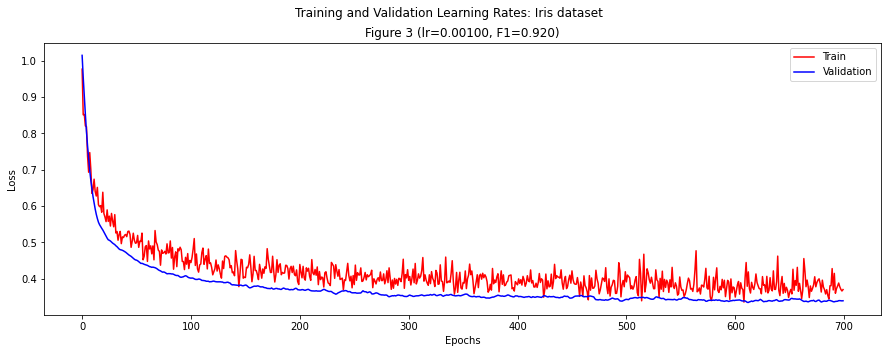

In [7]:
# set a network parameter
executor.set_network_parameter('dropout', 0.1)
executor.set_model_parameter('epochs', 700)
executor.set_model_parameter('learning_rate', .001)
run_model()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [8]:
# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.iteritems()))
    return (s,)
df = executor.get_predictions(transform=map_data_point)
df

using current results


,id,label,pred,correct,data
0,131,virginica,virginica,True,"sepal_length=7.9, sepal_width=3.8, petal_lengt..."
1,133,virginica,versicolor,False,"sepal_length=6.3, sepal_width=2.8, petal_lengt..."
2,135,virginica,virginica,True,"sepal_length=7.7, sepal_width=3.0, petal_lengt..."
3,137,virginica,virginica,True,"sepal_length=6.4, sepal_width=3.1, petal_lengt..."
4,147,virginica,virginica,True,"sepal_length=6.5, sepal_width=3.0, petal_lengt..."
5,148,virginica,virginica,True,"sepal_length=6.2, sepal_width=3.4, petal_lengt..."
6,149,virginica,virginica,True,"sepal_length=5.9, sepal_width=3.0, petal_lengt..."
7,17,setosa,setosa,True,"sepal_length=5.1, sepal_width=3.5, petal_lengt..."
8,30,setosa,setosa,True,"sepal_length=4.8, sepal_width=3.1, petal_lengt..."
9,31,setosa,setosa,True,"sepal_length=5.4, sepal_width=3.4, petal_lengt..."
